# A Generátor látens terében való keresés

Látens térben való keresés gradiens módszerrel

hibafüggvény: az L2 távolság minimalizálása

Jelölje $X$ a keresendő képet, $G$ a generátort, $\vec{z}$ pedig a látens vektort.

A cél egy olyan $\vec{z} \in \mathbb{R}^{100}$ látens vektor keresése, amellyel a lenti távolság minimalizálható.

$$ \min\left(\sum_{i=1}^{n\times m}\sqrt{(X_i-G(\vec{z})_i)^2}\right)$$

A képeket tehát pixelszinten hasonlítjuk össze kiindulásképp. Egyéb metrikákat is alkalmazhatunk a képek hasonlóságának mérésére, ilyen a PCA, a HOG, MSE, stb...

A keresés gradiens-módszerrel történik.

```python
noise = tf.Variable(random_noise, name='noise')
step_size = 0.1
steps = 50
for i in range(steps + 1):
    with tf.GradientTape() as g_tape:
        g_tape.watch(noise)

        generated_image = generator(noise, training=False)[0][0]
        loss = tf.norm(starter_image - generated_image)

    gradients = g_tape.gradient(loss, noise)
    noise = noise - (step_size * gradients)
```
Az algoritmus tehát:
Legyen $l$ a lépésméret, $X \in \mathbb{R}^{n\times m \times 3}$ a keresendő kép, $G$ pedig a betanított generátor.

1. Generáljunk egy képet az aktuális $\vec{z}$ zajvektorral
$$\hat X = G(\vec{z})$$
2. Számoljuk ki a generált kép és a keresendő kép távolságát.
$$ loss = \sum_{i=1}^{n\times m}\sqrt{(X_i-\hat X_i)^2} $$
3. Számoljuk ki a gradienseket a fenti függvény szerint
$$ \vec{grad} = \frac{d}{d\vec{z}} \left[loss\right]$$
4. Módosítsuk a $\vec{z}$ zajvektor elemeit a kapott gradiensek szerint
$$ z_i = z_i - (l \cdot grad_i)$$
5. Ismételjük meg az algoritmust a konvergálásig...

Ezen megközelítés az úgynevezett Gradient Descent, vagyis meghatározott $l$ távolságokkal lépkedve optimalizál az módszer.


Momentummal való kiegészítés:

Jelöljük $t$-vel az időpillanatot.

$$ z_i^t = z_i^{t-1} - (l \cdot f'(z_i^{t-1})$$

$$ valtozas^t = l \cdot f'(z_i^{t-1}) $$

$$ z_i^t = z_i^{t-1} - valtozas^t $$


Momentum esetén a változás:
$$ valtozas^t = l \cdot f'(z_i^{t-1}) + momentum \cdot valtozas^{t-1}$$


momentum 0 - 1 között (0 esetén sima gradient descent)

In [1]:
import tensorflow as tf
from tensorflow import keras

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

2022-03-26 15:37:34.407251: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-03-26 15:37:34.407288: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
generator = keras.models.load_model('datas/weights/generator.h5')

2022-03-26 15:37:37.651133: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-03-26 15:37:37.651170: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-03-26 15:37:37.651195: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (Inspiron-5558): /proc/driver/nvidia/version does not exist
2022-03-26 15:37:37.651433: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
def denormalize_image(image):
    return (image.numpy() * 127.5 + 127.5).astype("uint32")

In [4]:
latent_dim = 100

## A generátor által generált kép visszakeresése

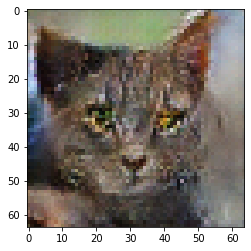

In [5]:
# Generate a random point, and an image from it
# this will be the goal image
tf.random.set_seed(195)
starter_image_noise = tf.random.normal([1, latent_dim])
starter_image = generator(starter_image_noise, training=False)[0][0]
plt.imshow(denormalize_image(starter_image))

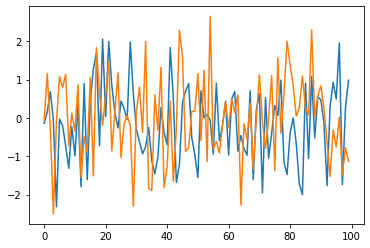

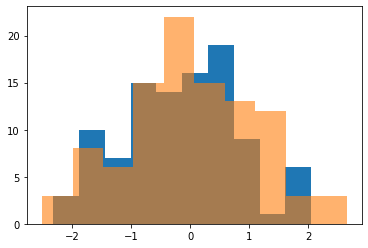

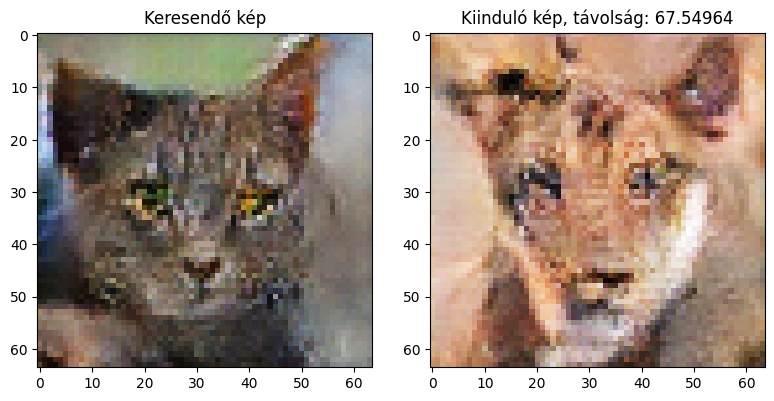

In [6]:
# generate a random starting point
random_noise = tf.random.normal([1, latent_dim])

plt.plot(starter_image_noise.numpy().flatten())
plt.plot(random_noise.numpy().flatten())
plt.show()

plt.hist(starter_image_noise.numpy().flatten())
plt.hist(random_noise.numpy().flatten(), alpha=0.6)
plt.show()

# generating an image from the random point
# and calculating the distance between the goal and the random image
random_image = generator(random_noise ,training=False)[0][0]

distance = tf.norm(starter_image-random_image)

fig, axes = plt.subplots(figsize=(8, 4), nrows=1, ncols=2, dpi=100)
plt.tight_layout()
axes[0].set_title("Keresendő kép")
axes[0].imshow(denormalize_image(starter_image), interpolation='none')

axes[1].set_title("Kiinduló kép" + ", távolság: " + str(distance.numpy()))
axes[1].imshow(denormalize_image(random_image), interpolation='none')

In [7]:
# Gradient Descent

def gradient_descent(goal_image, starting_noise, step_size, steps, verbose=False):
    noise = tf.Variable(starting_noise, name='noise')
    losses = []
    for i in range(steps + 1):
        with tf.GradientTape() as g_tape:
            g_tape.watch(noise)

            generated_image = generator(noise, training=False)[0][0]
            loss = tf.norm(goal_image - generated_image)

        gradients = g_tape.gradient(loss, noise)
        noise = noise - (step_size * gradients)

        if(verbose):
            print(f"Step: {i}, Loss: {loss}")
            plt.imshow(denormalize_image(generated_image))
            plt.show()

        losses.append(loss)
    return noise, losses

In [8]:
# Gradient Descent with Momentum

def gradient_descent_momentum(goal_image, starting_noise, step_size, momentum, steps, verbose=False):
    noise = tf.Variable(starting_noise, name='noise')

    change = 0
    losses = []
    for i in range(steps + 1):
        with tf.GradientTape() as g_tape:
            g_tape.watch(noise)

            generated_image = generator(noise, training=False)[0][0]
            loss = tf.norm(goal_image - generated_image)

        gradients = g_tape.gradient(loss, noise)
        change = (step_size * gradients) + momentum * change
        noise = noise - change
        
        if(verbose):
            print(f"Step: {i}, Loss: {loss}")
            plt.imshow(denormalize_image(generated_image))
            plt.show()

        losses.append(loss)
    return noise, losses

In [9]:
gradient_noise, gd_losses = gradient_descent(starter_image, random_noise, step_size=0.1, steps=50)

In [10]:
gradient_momentum_noise, gdm_losses =\
    gradient_descent_momentum(starter_image, random_noise, step_size=0.1, momentum=0.9, steps=50)

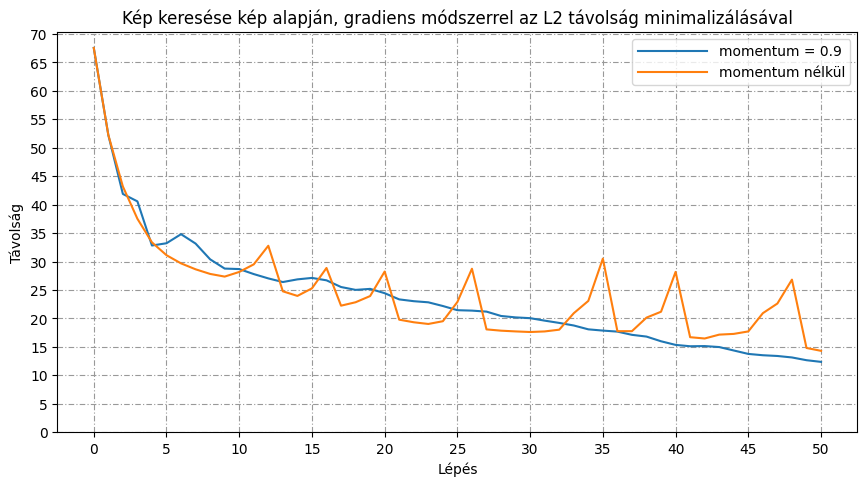

In [11]:
fig_1 = plt.figure(figsize=(8, 4), dpi=100)
ax = fig_1.add_axes([0, 0, 1, 1])
ax.set_xlabel('Lépés')
ax.set_ylabel('Távolság')
ax.set_title('Kép keresése kép alapján, gradiens módszerrel az L2 távolság minimalizálásával')

ax.grid(True, color='0.6', dashes=(5, 2, 1, 2))

ax.plot(gdm_losses, label="momentum = 0.9")
ax.plot(gd_losses, label="momentum nélkül")
ax.set_ylim(bottom=0)
ax.yaxis.set_major_locator(ticker.MultipleLocator(5))
ax.xaxis.set_major_locator(ticker.MultipleLocator(5))
ax.legend(loc=0, handlelength=5)
plt.show()

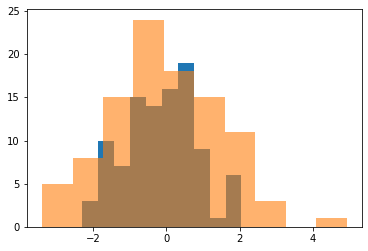

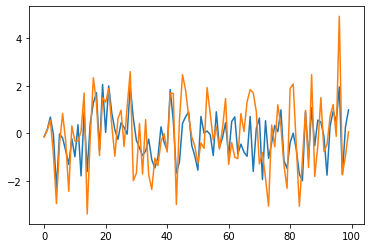

In [12]:
plt.hist(starter_image_noise.numpy().flatten())
plt.hist(gradient_momentum_noise.numpy().flatten(), alpha=0.6)
plt.show()

plt.plot(starter_image_noise.numpy().flatten())
plt.plot(gradient_momentum_noise.numpy().flatten())
plt.show()

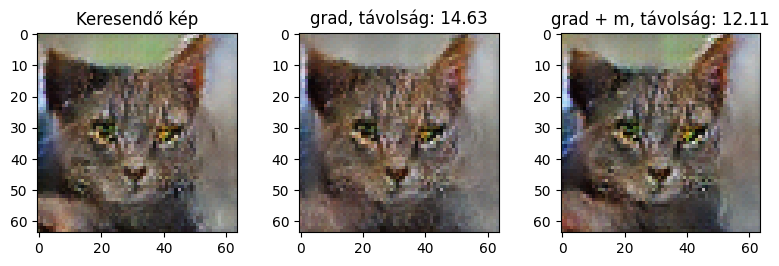

In [13]:
grad_image = generator(gradient_noise, training=False)[0][0]

grad_momentum_image = generator(gradient_momentum_noise, training=False)[0][0]

distance_grad = tf.norm(starter_image - grad_image)
distance_grad_momentum = tf.norm(starter_image - grad_momentum_image)

fig, axes = plt.subplots(figsize=(8, 4), nrows=1, ncols=3, dpi=100)
plt.tight_layout()
axes[0].set_title("Keresendő kép")
axes[0].imshow(denormalize_image(starter_image), interpolation='none')

axes[1].set_title("grad" + ", távolság: " + '{0:.2f}'.format(distance_grad.numpy()))
axes[1].imshow(denormalize_image(grad_image), interpolation='none')

axes[2].set_title("grad + m" + ", távolság: " + '{0:.2f}'.format(distance_grad_momentum.numpy()))
axes[2].imshow(denormalize_image(grad_momentum_image), interpolation='none')

## Validációs halmazban szereplő kép legközeli generált képének megtatálása

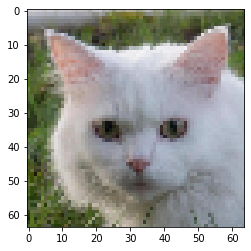

In [14]:
validating_image = plt.imread("./datas/afhq/val/cat/flickr_cat_000176.jpg")

# Resize it to 64x64
resized = tf.image.resize(validating_image, [64, 64])

resized = (resized - 127.5) / 127.5  # Normalize image

plt.imshow(denormalize_image(resized))

Distance : 29.220090866088867


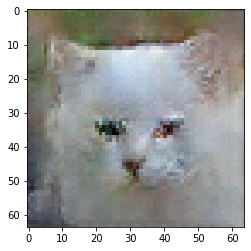

In [15]:
tf.random.set_seed(26)
noise = tf.random.normal([1, latent_dim])

found_noise, _ = gradient_descent_momentum(resized, noise, step_size=0.1, momentum=0.8, steps=20)

found_image = generator(found_noise, training=False)[0][0]
plt.imshow(denormalize_image(found_image))
print(f"Distance : {tf.norm(resized - found_image)}")